In [1]:
import numpy as np

In [2]:
from PIL import Image
from tqdm import tqdm

In [3]:
import os
annot_fps = [
    '/media/dh/HDD/pp/pp_modir/pp.train.txt',
    '/media/dh/HDD/pp/pp_modir/pp.val.txt',
# '/media/dh/Data/SGMaritimeDataset/VIS_Onboard_annot_contexted.txt',
# '/media/dh/DATA4TB/Datasets/SGMaritimeDataset/VIS_Onshore_annot_contexted.txt',
# '/media/dh/Data/SGMaritimeDataset/NIR_annot_contexted.txt',
# '/media/dh/Data/SeaShips(7000)/trainval_contexted.txt'
            ]
lines = []
for fp in annot_fps:
    assert os.path.exists(fp)
    with open (fp,'r') as f:
        this_lines = f.readlines()
        lines.extend(this_lines)
    print('{}: {}'.format(os.path.basename(fp), len(this_lines)))

pp.train.txt: 23149
pp.val.txt: 4587


In [4]:
import os
annot_fps = [
    '/media/dh/HDD/pp/pp_modir/pp_finetune.train.txt',
    '/media/dh/HDD/pp/pp_modir/pp_finetune.val.txt',
# '/media/dh/Data/SGMaritimeDataset/VIS_Onboard_annot_contexted.txt',
# '/media/dh/DATA4TB/Datasets/SGMaritimeDataset/VIS_Onshore_annot_contexted.txt',
# '/media/dh/Data/SGMaritimeDataset/NIR_annot_contexted.txt',
# '/media/dh/Data/SeaShips(7000)/trainval_contexted.txt'
            ]
lines_ft = []
for fp in annot_fps:
    assert os.path.exists(fp)
    with open (fp,'r') as f:
        this_lines = f.readlines()
        lines_ft.extend(this_lines)
    print('{}: {}'.format(os.path.basename(fp), len(this_lines)))

pp_finetune.train.txt: 6117
pp_finetune.val.txt: 1931


<b> FOR DARKNET ANNOTATION FORMAT </b>

In [7]:
network_input_min_size = 800

In [8]:
all_bbs = []
all_image_sizes = []
for line in tqdm(lines):
    img_path = line.strip()
    
    im = Image.open(img_path)
    iw, ih = im.size
    all_image_sizes.append((int(iw), int(ih)))
    
    iAR = ih / iw
    scaled_ih = network_input_min_size
    scaled_iw = scaled_ih / iAR
    
    label_path = img_path.replace('images','labels') 
    label_path = label_path.replace('.jpg','.txt') 
    label_path = label_path.replace('.png','.txt') 
    assert os.path.exists(label_path)
    with open(label_path,'r') as f:
        bbs = f.readlines()
    for bb in bbs:
        _, _, _, w, h = bb.strip().split()
        all_bbs.append((float(w)*scaled_iw,float(h)*scaled_ih))
all_bbs = np.array(all_bbs)
all_bbs.shape

 59%|█████▉    | 16411/27736 [07:32<05:03, 37.31it/s]

KeyboardInterrupt: 

 59%|█████▉    | 16411/27736 [07:50<05:03, 37.31it/s]

In [87]:
all_bbs_ft = []
all_image_sizes_ft = []
for line in tqdm(lines_ft):
    img_path = line.strip()
    
    im = Image.open(img_path)
    iw, ih = im.size
    all_image_sizes_ft.append((int(iw), int(ih)))
    
    iAR = ih / iw
    scaled_ih = network_input_min_size
    scaled_iw = scaled_ih / iAR
    
    label_path = img_path.replace('images','labels') 
    label_path = label_path.replace('.jpg','.txt') 
    label_path = label_path.replace('.png','.txt') 
    assert os.path.exists(label_path)
    with open(label_path,'r') as f:
        bbs = f.readlines()
    for bb in bbs:
        _, _, _, w, h = bb.strip().split()
        all_bbs_ft.append((float(w)*scaled_iw,float(h)*scaled_ih))
all_bbs_ft = np.array(all_bbs_ft)
all_bbs_ft.shape





  0%|          | 0/8048 [00:00<?, ?it/s]



 15%|█▍        | 1175/8048 [00:00<00:00, 11749.14it/s]



 29%|██▉       | 2314/8048 [00:00<00:00, 11638.59it/s]



 43%|████▎     | 3488/8048 [00:00<00:00, 11662.20it/s]



 58%|█████▊    | 4645/8048 [00:00<00:00, 11634.38it/s]



 72%|███████▏  | 5815/8048 [00:00<00:00, 11649.25it/s]



 87%|████████▋ | 7016/8048 [00:00<00:00, 11753.04it/s]



100%|██████████| 8048/8048 [00:00<00:00, 11693.31it/s]

(16102, 2)

<b> For Faster-RCNN Anchors </b>

In [ ]:
aspect_ratios = all_bbs[:, 1] / all_bbs[:, 0]
aspect_ratios = aspect_ratios.reshape(-1,1)
print(aspect_ratios.shape)

areas = np.sqrt( all_bbs[:,0] * all_bbs[:,1] )
areas = areas.reshape(-1,1)
print(areas.shape)

all_ar_areas = np.concatenate((aspect_ratios, areas), axis=1)
print(all_ar_areas.shape)

In [ ]:
aspect_ratios_ft = all_bbs_ft[:, 1] / all_bbs_ft[:, 0]
aspect_ratios_ft = aspect_ratios_ft.reshape(-1,1)
print(aspect_ratios_ft.shape)

areas_ft = np.sqrt( all_bbs_ft[:,0] * all_bbs_ft[:,1] )
areas_ft = areas.reshape(-1,1)
print(areas_ft.shape)

all_ar_areas_ft = np.concatenate((aspect_ratios_ft, areas_ft), axis=1)
print(all_ar_areas_ft.shape)

In [55]:
from sklearn.cluster import KMeans as KMeans_sk

In [94]:
ar_kmeans = KMeans_sk(n_clusters=3)
ar_cluster = ar_kmeans.fit(aspect_ratios)

In [139]:
ar_cluster_centers = sorted(ar_cluster.cluster_centers_.flatten().tolist())
print('[[{:.1f}, {:.1f}, {:.1f}]]'.format(*ar_cluster_centers))

[[0.4, 1.3, 3.1]]


In [95]:
ar_labels = ar_kmeans.predict(aspect_ratios)

In [106]:
area_kmeans = KMeans_sk(n_clusters=5)
area_cluster = area_kmeans.fit(areas)

In [140]:
area_cluster_centers = sorted(area_cluster.cluster_centers_.flatten().tolist())
print('[[{:.0f}], [{:.0f}], [{:.0f}], [{:.0f}], [{:.0f}]]'.format(*area_cluster_centers))

[[43, 117, 217, 348, 521]]


In [107]:
area_labels = area_kmeans.predict(areas)

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

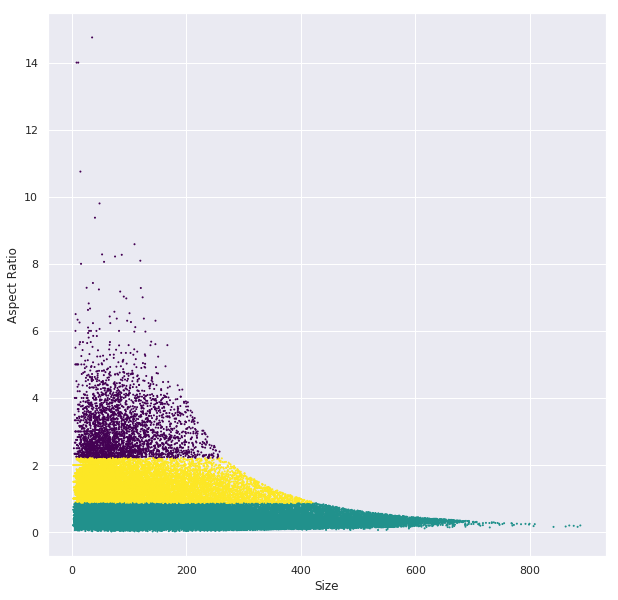

In [120]:
plt.figure(figsize=(10,10))
plt.scatter(all_ar_areas[:, 1], all_ar_areas[:, 0], c=ar_labels, s=1, cmap='viridis')
plt.xlabel('Size')
plt.ylabel('Aspect Ratio')

plt.savefig('pp_modir-AR_clusters')

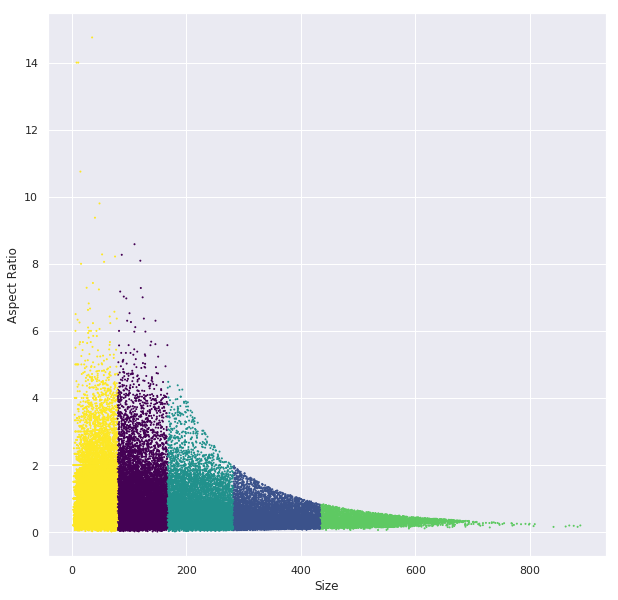

In [121]:
plt.figure(figsize=(10,10))
plt.scatter(all_ar_areas[:, 1], all_ar_areas[:, 0], c=area_labels, s=1, cmap='viridis')
plt.xlabel('Size')
plt.ylabel('Aspect Ratio')

plt.savefig('pp_modir-Area_clusters')

In [110]:
ar_kmeans_ft = KMeans_sk(n_clusters=3)
ar_cluster_ft = ar_kmeans_ft.fit(aspect_ratios_ft)

In [130]:
ar_cluster_centers_ft = sorted(ar_cluster_ft.cluster_centers_.flatten().tolist())
print(ar_cluster_centers_ft)

[0.25153854601176906, 0.804877427727325, 2.031464354604651]


In [112]:
ar_labels_ft = ar_kmeans_ft.predict(aspect_ratios_ft)

In [113]:
area_kmeans_ft = KMeans_sk(n_clusters=5)
area_cluster_ft = area_kmeans_ft.fit(areas_ft)

In [128]:
area_cluster_centers_ft = area_cluster_ft.cluster_centers_.flatten().tolist()
area_cluster_centers_ft = sorted(area_cluster_centers_ft)
print(area_cluster_centers)

[52.442195221450746, 130.90205917504397, 224.04677441446051, 331.3408041438813, 478.6651580134166]


In [115]:
area_labels_ft = area_kmeans_ft.predict(areas_ft)

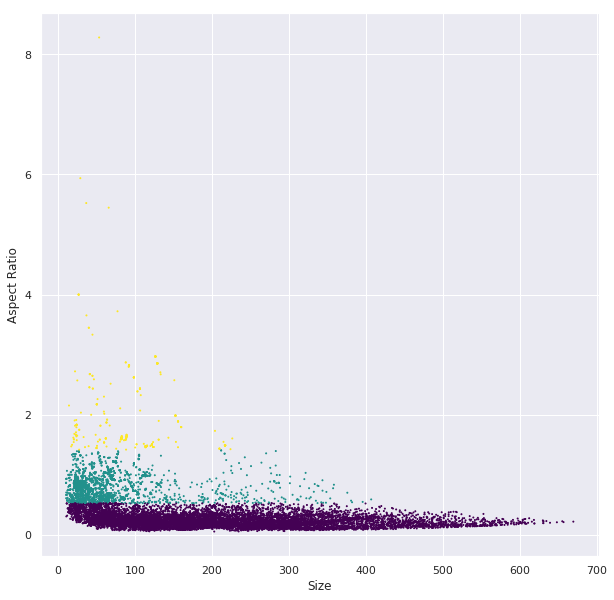

In [123]:
plt.figure(figsize=(10,10))
plt.scatter(all_ar_areas_ft[:, 1], all_ar_areas_ft[:, 0], c=ar_labels_ft, s=1, cmap='viridis')
plt.xlabel('Size')
plt.ylabel('Aspect Ratio')

plt.savefig('pp_modir_finetune-AR_clusters')

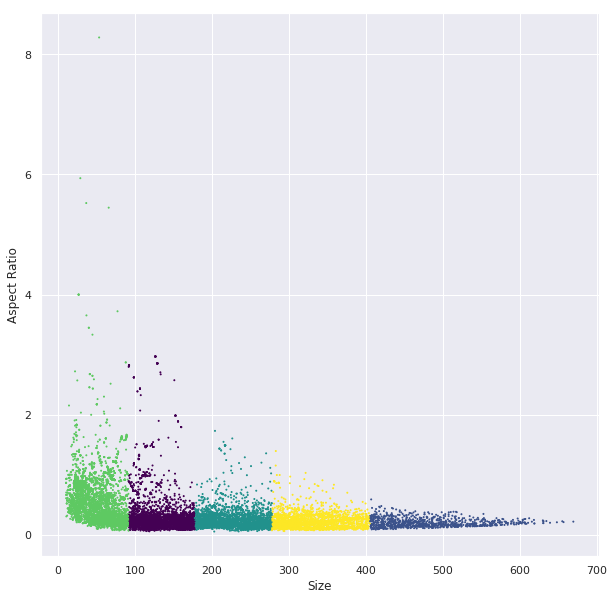

In [119]:
plt.figure(figsize=(10,10))
plt.scatter(all_ar_areas_ft[:, 1], all_ar_areas_ft[:, 0], c=area_labels_ft, s=1, cmap='viridis')
plt.xlabel('Size')
plt.ylabel('Aspect Ratio')

plt.savefig('pp_modir_finetune-Area_clusters')

In [56]:
feature_maps = [64, 32, 16, 8, 4, 2, 1]
img_dim = 512
# nanchors = [6,8,8,8,8,4,4]
nanchors = [6,6,6,6,6,4,4]
tot_anchors = sum(np.array(feature_maps)**2 * nanchors)
print(tot_anchors)

32756


In [57]:
k = sum(nanchors)
anchors = kmeans(all_bbs, k)
anchors

array([[0.18125   , 0.04538799],
       [0.35625   , 0.19444444],
       [0.04785156, 0.08463542],
       [0.2265625 , 0.09635417],
       [0.05957031, 0.02604167],
       [0.11230469, 0.05462963],
       [0.17089844, 0.13030747],
       [0.0078125 , 0.00781759],
       [0.07128906, 0.12326389],
       [0.87295082, 0.421875  ],
       [0.8171875 , 0.25911458],
       [0.04003906, 0.03776042],
       [0.0703125 , 0.0625    ],
       [0.04785156, 0.05277778],
       [0.03710938, 0.13333333],
       [0.203125  , 0.20547945],
       [0.02636719, 0.06423358],
       [0.26614583, 0.14259259],
       [0.30625   , 0.06481481],
       [0.06542969, 0.22615385],
       [0.10351562, 0.03380783],
       [0.25292969, 0.33071895],
       [0.07128906, 0.04166667],
       [0.01171875, 0.01666667],
       [0.11035156, 0.17798165],
       [0.01660156, 0.02777778],
       [0.39355469, 0.39355469],
       [0.39355469, 0.11388889],
       [0.6722886 , 0.14444444],
       [0.03613281, 0.01953125],
       [0.

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
from copy import deepcopy

In [58]:
anchors_list = list(anchors)
anchors_list.sort(key= lambda x: x[0]*x[1])

In [59]:
anchors_scales = []
anchors_list_temp = deepcopy(anchors_list)
for n in nanchors:
    anchors_scales.append(anchors_list_temp[:n])
    del anchors_list_temp[:n]
# n = 3
# anchors_scales = [anchors_list[i:i+n] for i in range(0, len(anchors_list), n)]
anchors_scales

[[array([0.0078125 , 0.00781759]),
  array([0.01171875, 0.01666667]),
  array([0.02246094, 0.01321586]),
  array([0.01660156, 0.02777778]),
  array([0.03613281, 0.01953125]),
  array([0.02636719, 0.03221083])],
 [array([0.04003906, 0.03776042]),
  array([0.05957031, 0.02604167]),
  array([0.02636719, 0.06423358]),
  array([0.04785156, 0.05277778]),
  array([0.07128906, 0.04166667]),
  array([0.10351562, 0.03380783])],
 [array([0.04785156, 0.08463542]),
  array([0.0703125, 0.0625   ]),
  array([0.03710938, 0.13333333]),
  array([0.11230469, 0.05462963]),
  array([0.09375   , 0.08240741]),
  array([0.18125   , 0.04538799])],
 [array([0.07128906, 0.12326389]),
  array([0.15820312, 0.07291667]),
  array([0.125     , 0.10416667]),
  array([0.06542969, 0.22615385]),
  array([0.11035156, 0.17798165]),
  array([0.30625   , 0.06481481])],
 [array([0.2265625 , 0.09635417]),
  array([0.17089844, 0.13030747]),
  array([0.26614583, 0.14259259]),
  array([0.203125  , 0.20547945]),
  array([0.1337890

In [60]:
BIG_ACC = []
for list_of_pairs in anchors_scales:
    acc = []
    for pair in list_of_pairs:
        acc.append( (pair * img_dim).astype(np.int32).tolist() )
    BIG_ACC.append(acc)
print(BIG_ACC)

[[[4, 4], [6, 8], [11, 6], [8, 14], [18, 10], [13, 16]], [[20, 19], [30, 13], [13, 32], [24, 27], [36, 21], [53, 17]], [[24, 43], [36, 32], [19, 68], [57, 27], [48, 42], [92, 23]], [[36, 63], [81, 37], [64, 53], [33, 115], [56, 91], [156, 33]], [[116, 49], [87, 66], [136, 73], [104, 105], [68, 165], [201, 58]], [[182, 99], [129, 169], [344, 73], [260, 120]], [[201, 201], [418, 132], [306, 184], [446, 216]]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

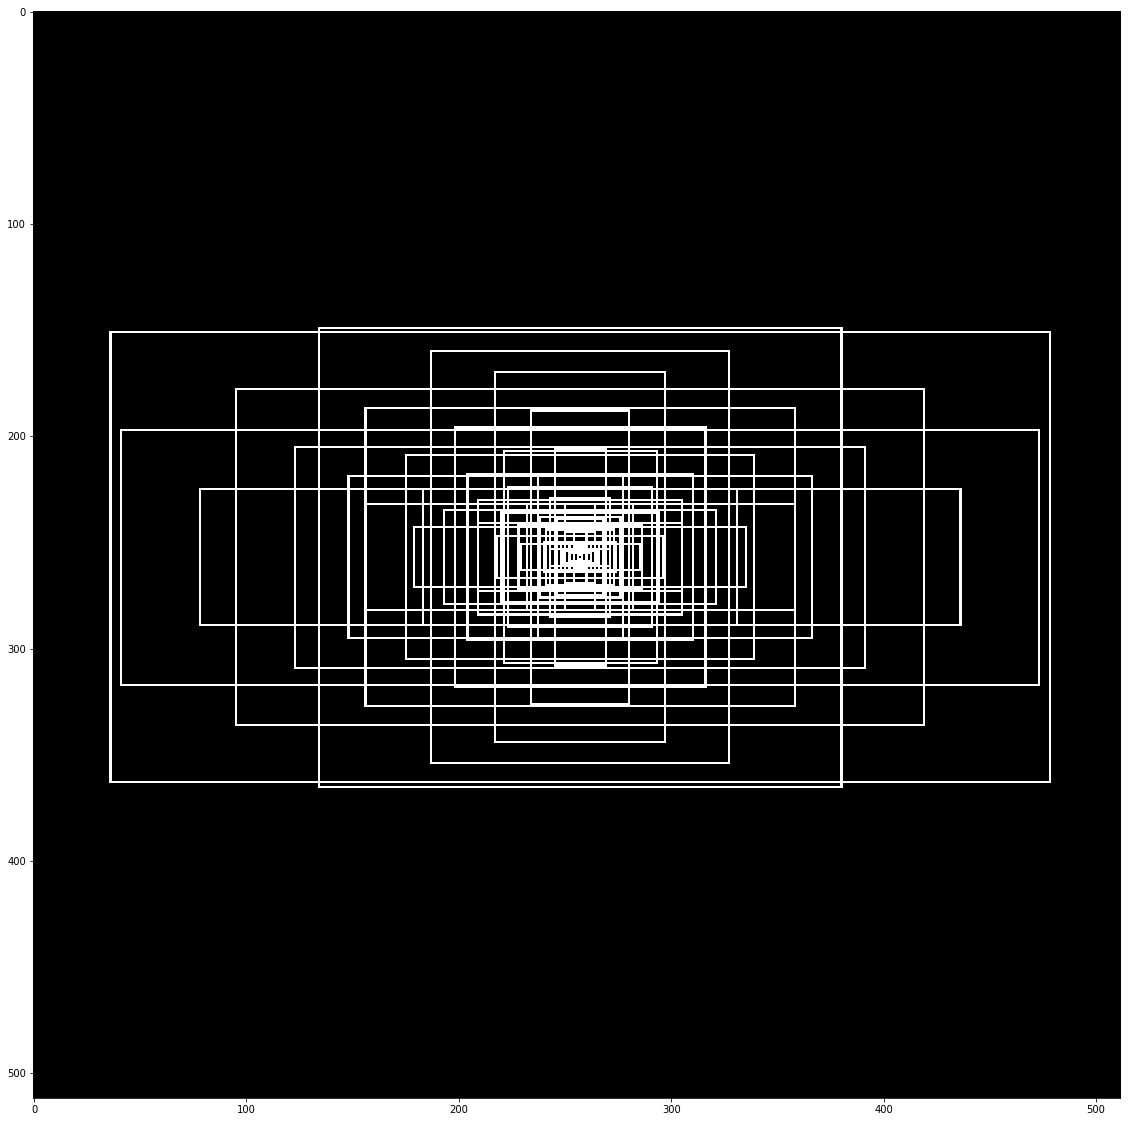

In [48]:
import random

# ih, iw = 1080, 1920
ih, iw = 512, 512
sketchboard2 = np.zeros((ih, iw, 3))
zoom = 1
colors = [ (218, 245, 66), (69,245,66), (173, 110, 240)]
colors = [tuple(np.random.choice(range(256),size=3)) for _ in range(len(anchors_scales))]
for i, anchors in enumerate(anchors_scales):
#     color = (random.randint(100,255), random.randint(100,255), random.randint(100,255))
    color = colors[i]
    for bb in anchors:
        nw, nh = bb
        w = nw * iw * zoom
        h = nh * ih * zoom
        mid_x = int(iw/2+1)
        mid_y = int(ih/2+1)
        x_min = mid_x - int(w/2-1)  
        x_max = mid_x + int(w/2-1)  
        y_min = mid_y - int(h/2-1)  
        y_max = mid_y + int(h/2-1)  
        color  = tuple([int(c) for c in color])
        cv2.rectangle(sketchboard2, (x_min, y_min), (x_max, y_max), color, thickness=1 )
#         cv2.rectangle(sketchboard2, (x_min, y_min), (x_max, y_max),  color)


plt.figure(figsize = (20,20))
plt.imshow(sketchboard2)
cv2.imwrite('anchor_viz_scales_RFB.png',sketchboard2)

In [48]:
iw, ih = 448, 448

print(anchors_scales)
new_anch_bbs = []
for anchors in anchors_scales:
    for bb in anchors:
        new_bb = [int(bb[0]*iw), int(bb[1]*ih)]
        print(new_bb)
        new_anch_bbs.append(new_bb)

[[array([0.01757812, 0.01692708]), array([0.03808594, 0.02962963]), array([0.04492188, 0.06901042])], [array([0.09082031, 0.04411765]), array([0.078125  , 0.14322917]), array([0.16894531, 0.0859375 ])], [array([0.359375  , 0.13932292]), array([0.19628906, 0.26041667]), array([0.63183594, 0.31738281])]]
[7, 7]
[17, 13]
[20, 30]
[40, 19]
[35, 64]
[75, 38]
[161, 62]
[87, 116]
[283, 142]


In [49]:
with open('anchors.txt','w') as f:
    f.write('@Resolution(w x h): {} x {}\n'.format(iw, ih))
    for bb in new_anch_bbs:
        f.write('{},{}, '.format(*bb))

In [51]:
yolo_anchors = np.array([[[10,13],  [16,30],  [33,23]],  [[30,61],  [62,45],  [59,119]],  [[116,90],  [156,198],  [373,326]]])
yolo_anchors_norm = yolo_anchors/416.0
yolo_anchors_norm

array([[[0.02403846, 0.03125   ],
        [0.03846154, 0.07211538],
        [0.07932692, 0.05528846]],

       [[0.07211538, 0.14663462],
        [0.14903846, 0.10817308],
        [0.14182692, 0.28605769]],

       [[0.27884615, 0.21634615],
        [0.375     , 0.47596154],
        [0.89663462, 0.78365385]]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

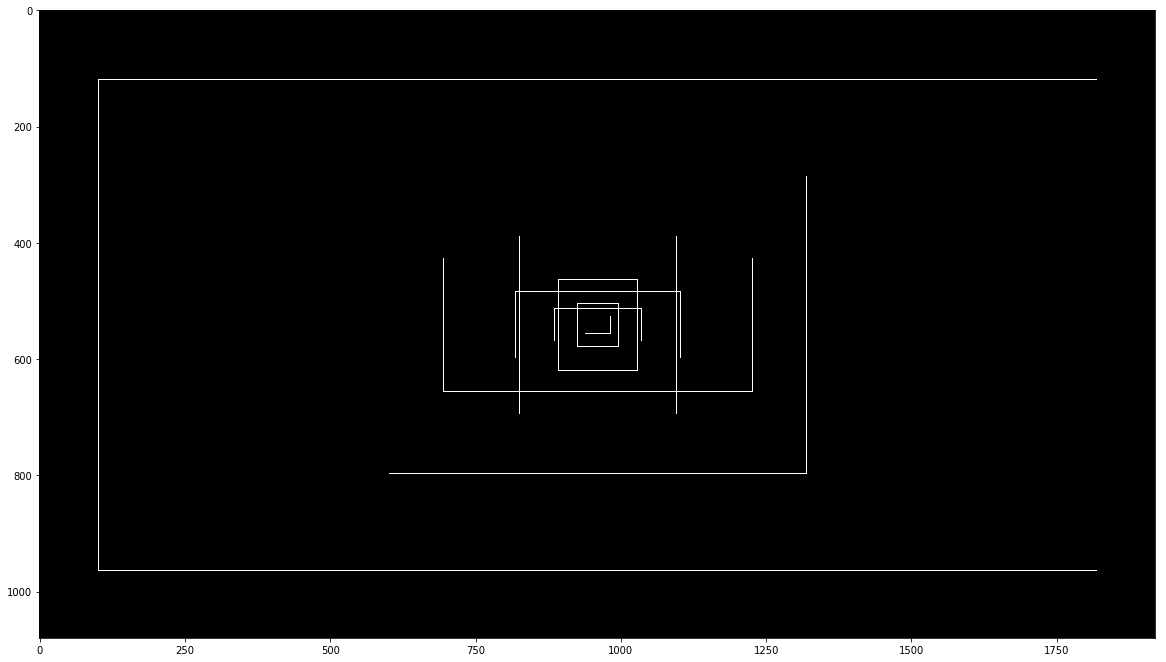

In [52]:
import random

ih, iw = 1080, 1920
sketchboard2 = np.zeros((ih, iw, 3))
zoom = 1
colors = [ (218, 245, 66), (69,245,66), (173, 110, 240)]
for i, anchors in enumerate(yolo_anchors_norm):
#     color = (random.randint(100,255), random.randint(100,255), random.randint(100,255))
    color = colors[i]
    for bb in anchors:
        nw, nh = bb
        w = nw * iw * zoom
        h = nh * ih * zoom
        mid_x = int(iw/2+1)
        mid_y = int(ih/2+1)
        x_min = mid_x - int(w/2-1)  
        x_max = mid_x + int(w/2-1)  
        y_min = mid_y - int(h/2-1)  
        y_max = mid_y + int(h/2-1)  
        cv2.rectangle(sketchboard2, (x_min, y_min), (x_max, y_max), color, thickness=1 )


plt.figure(figsize = (20,20))
plt.imshow(sketchboard2)
cv2.imwrite('yolo_anchor_viz_scales.png',sketchboard2)